# Imports 

In [15]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from initialization import Location
from initialization import Grid
import pandas as pd
import seaborn as sns
from SIRD_initialization import Grid


# Basic SIRD Model

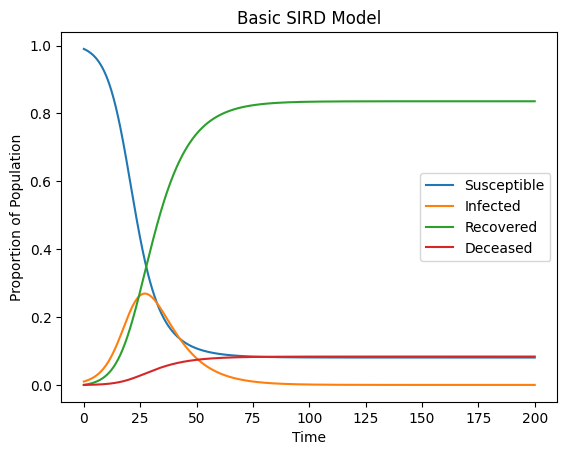

In [16]:
# Define the SIRD model differential equations.
def sird_model(y, t, beta, gamma, delta):
    S, I, R, D = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I - delta * I
    dRdt = gamma * I
    dDdt = delta * I
    return [dSdt, dIdt, dRdt, dDdt]

# Set the initial conditions and parameters.
initial_conditions = [0.99, 0.01, 0, 0]  # S, I, R, D
beta = 0.3  # Infection rate
gamma = 0.1  # Recovery rate
delta = 0.01  # Death rate

# Set the time points for the simulation.
t = np.linspace(0, 200, 1000)

# Solve the ODEs using odeint.
solution = odeint(sird_model, initial_conditions, t, args=(beta, gamma, delta))

# Extract the results.
S, I, R, D = solution.T

# Plot the results.
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.plot(t, D, label='Deceased')
plt.xlabel('Time')
plt.ylabel('Proportion of Population')
plt.title('Basic SIRD Model')
plt.legend()
plt.show()


## Mobility Based SIRD Model - Random, High, Low

In [17]:
def dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alpha_range, trials, c, delta_c, delta_g, birth_rate):
    alpha_sir = {}
    for alpha in alpha_range:
        susceptible = np.zeros(days)
        infectious = np.zeros(days)
        recovered = np.zeros(days) 
        dead = np.zeros(days)
        for trial in range(trials):
    
            # Initialize grid and locations
            grid = Grid(n_locations, N, alpha, beta, mu, c)

            # Initialize random starting location based on chosen Mobility Type
            if type == "Random":
                grid.random_orgin()
            elif type == "High Mobility":
                grid.mobility_based_origin(threshold, True)
            else:
                grid.mobility_based_origin(threshold, False)

            for day in range(days):
                for loc in grid.map:
                    if loc.n != 0:
                        infections, total_connections = get_other_loc_params(grid, loc)

                        # find new infections
                        new_infections = (beta * loc.s * loc.i/ loc.n) + ((alpha*loc.s*infections*beta)/(loc.n+total_connections))

                        # update infections in the location
                        loc.i += new_infections 
                        loc.s -= new_infections
                        
                        # determine number of deaths and remove from population
                        infection_deaths = delta_c * loc.i
                        loc.i -= infection_deaths
                        loc.n -= infection_deaths 
                        loc.d += infection_deaths
                        
                        general_deaths = delta_g * loc.n
                        loc.s -= general_deaths
                        loc.n -= general_deaths
                        loc.d += general_deaths

                        # determine new recoveris
                        new_recoveries = (mu * loc.i) / loc.n
                        loc.i -=  new_recoveries                        
                        loc.r += new_recoveries

                        # birth rate impact on the population
                        born = birth_rate*loc.s
                        loc.n += born 
                        loc.s += born 

                        susceptible[day] += loc.s
                        infectious[day] += loc.i
                        recovered[day] += loc.r
                        dead[day] += loc.d


        susceptible = [day / (trials*N) for day in susceptible]
        infectious = [day / (trials*N) for day in infectious]
        recovered = [day / (trials*N) for day in recovered]
        dead = [day / (trials*N) for day in dead]

        susceptible.insert(0,1)
        infectious.insert(0,1/N)
        recovered.insert(0,0)
        dead.insert(0,0)

        alpha_sir[alpha] = [susceptible, infectious, recovered, dead]
    print(alpha_sir)
    return alpha_sir

def sir_plotting(results, type):
    translation = {0:"S", 1:"I", 2:"R", 3:"D"}
    for key, values in results:
        plt.figure()
        for sublist in values:
            plt.plot(sublist, label=translation[values.index(sublist)])
            plt.title(f'SIR Model w/ {type} Mobility: Alpha = {key}')

        plt.legend()
        plt.xlabel("Generations")
        plt.ylabel("Population Density")
    plt.show()


def get_other_loc_params(grid,loc):
    infections = 0
    total_connections = 0
    for j in loc.connections:
        if grid.map[j].n != 0:
            infections += loc.connections[j] * (grid.map[j].i / grid.map[j].n)
            total_connections += loc.connections[j]
    
    return infections, total_connections

{0.1: [[1, 0.9967643642629475, 0.9944542823304242, 0.9920514306924202, 0.9895336687174374, 0.9868744853778207, 0.9840424881888669, 0.9810010074169951, 0.977707914993604, 0.9741157808774858, 0.9701725003475064, 0.9658225106049924, 0.9610086598380798, 0.9556746873928765, 0.9497681241574861, 0.9432432510072475, 0.9360635988417764, 0.9282033749998353, 0.9196471792590352, 0.9103874351855484, 0.9004191387449693, 0.8897319208107272, 0.8783002049000547, 0.8660734752005774, 0.8529699855580833, 0.8388777464341439, 0.8236654147627865, 0.807202708349831, 0.7893862673067106, 0.7701641620417148, 0.7495518288426618, 0.7276345289141748, 0.7045558596988505, 0.6804968048912223, 0.6556531096677913, 0.6302186316088215, 0.6043786611724912, 0.5783120251632148, 0.5521968608387535, 0.5262140148132226, 0.5005441709291155, 0.47535886701122554, 0.45080931427186033, 0.4270179067242764, 0.40407483256239574, 0.3820386924752901, 0.36093889859435163, 0.3407795001699626, 0.32154599845594717, 0.3032156937873826, 0.2857

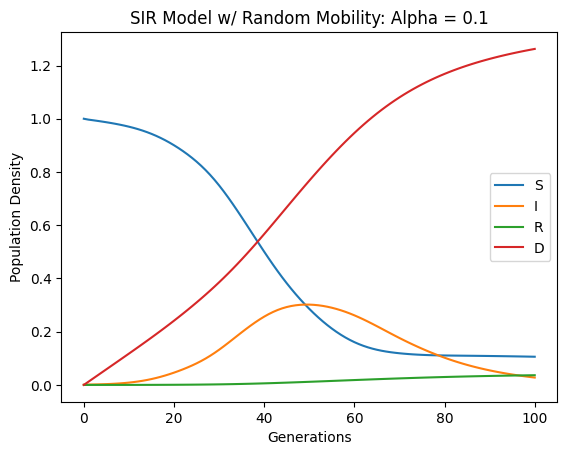

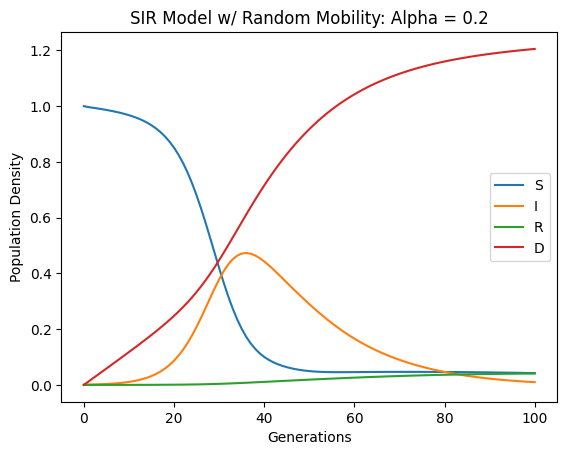

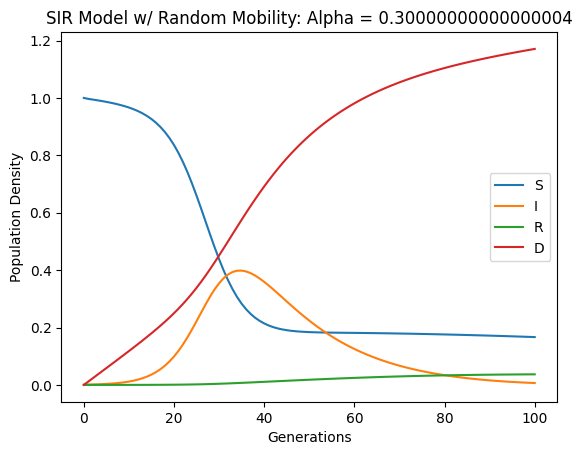

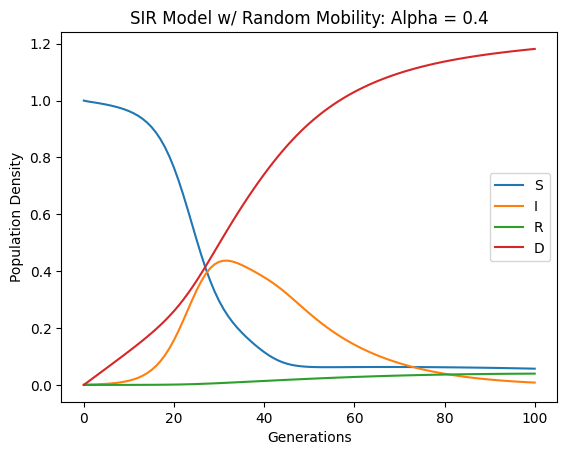

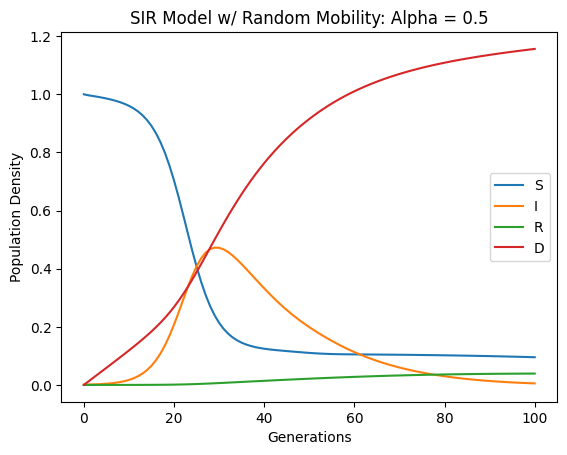

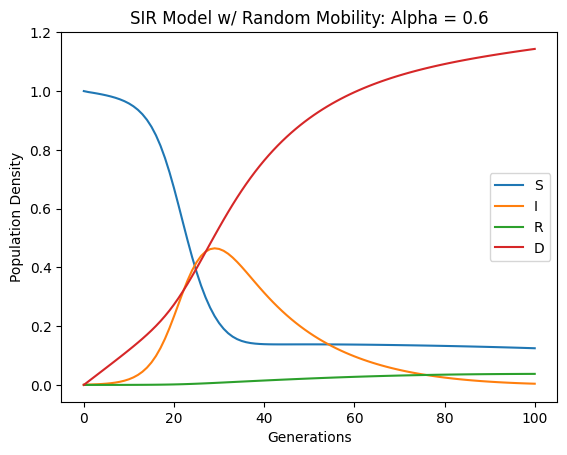

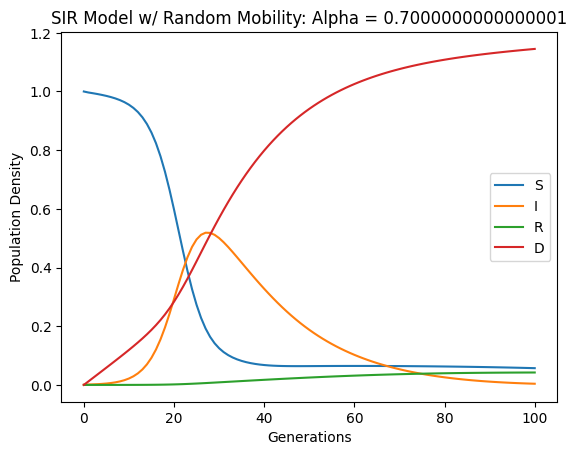

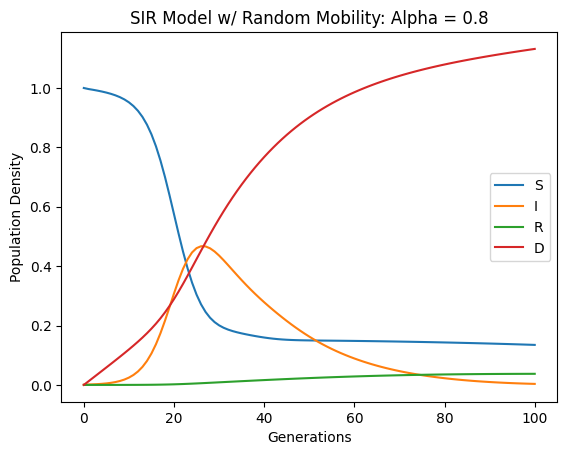

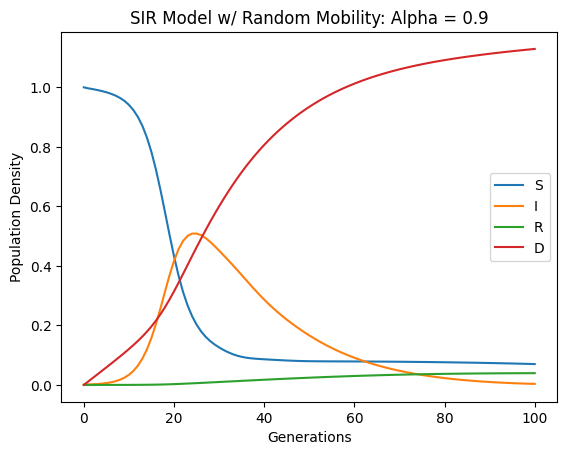

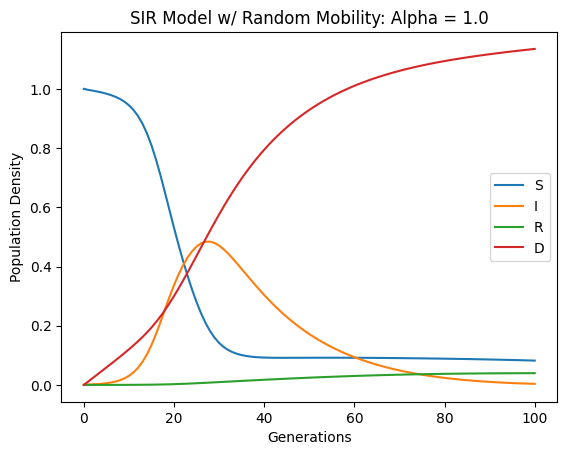

In [20]:
beta = 0.3 # rate of infection *CHANGE LATER MAYBE*
mu = 0.1 # rate of recovery *CHANGE LATER MAYBE*
delta_c = 0.04 # rate of death from COVID for Estonia
delta_g = 0.0117 # general death rate in Estonia
birth_rate = 0.009898
N = 1000 
n_locations=10
days = 100
alphas = np.arange(0.1,1.1,0.1)
trials=10
c = 0
type = "Random"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials, c, delta_c, delta_g, birth_rate)
sir_plotting(dynamic_alpha_results.items(), type)
